{0: 'Arnold_Schwarzenegger', 1: 'George_W_Bush', 2: 'Junichiro_Koizumi', 3: 'Tony_Blair', 4: 'Vladimir_Putin'}
Epoch 1/2, Loss: 1.5180671451744099
Epoch 2/2, Loss: 1.2537753864870234
0.42041 : George_W_Bush
0.37427 : Tony_Blair
0.11908 : Vladimir_Putin
0.04492 : Arnold_Schwarzenegger
0.04135 : Junichiro_Koizumi


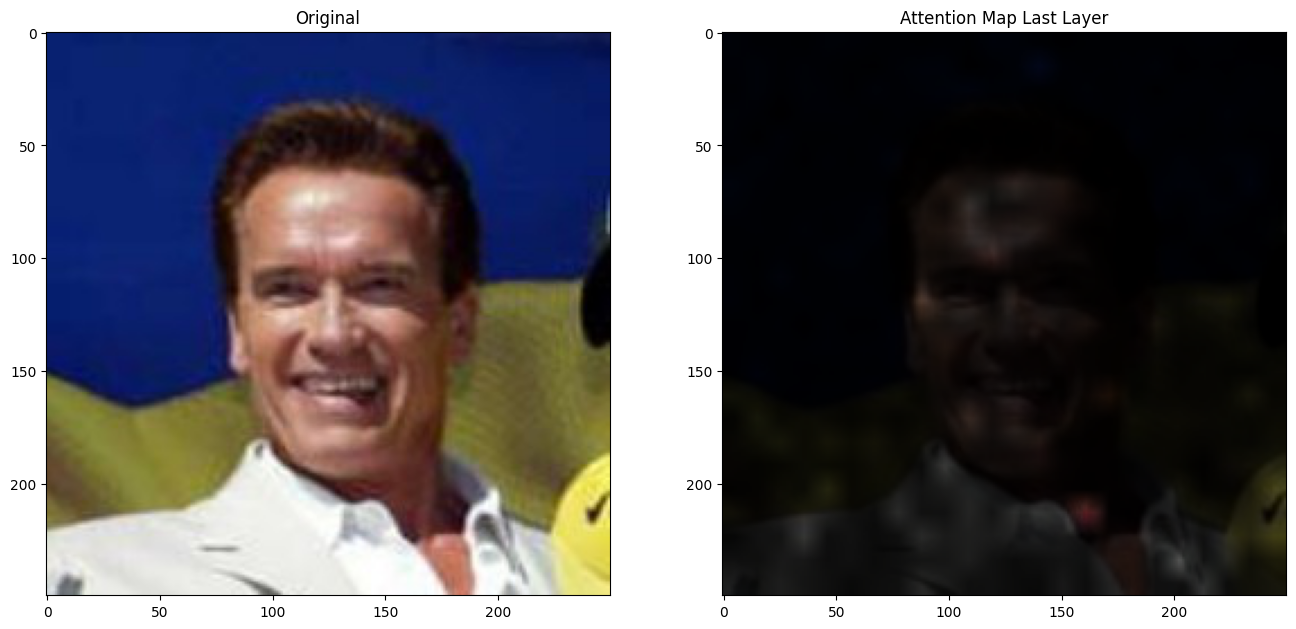

In [1]:
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torch.optim import Optimizer
import math

from VisionTransformerPytorch.vision_transformer_pytorch import VisionTransformer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ViT model
model = VisionTransformer.from_name('ViT-B_16', num_classes=5).to(device)

# Helper functions
def load_state(model_path):
    state_dict = torch.load(model_path)['model']
    state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
    state_dict = {k[6:] if k.startswith('model.') else k: state_dict[k] for k in state_dict.keys()}
    return state_dict

def get_attention_map(img, get_mask=False):
    x = transform(img)
    x = x.unsqueeze(0).to(device)

    logits, att_mat = model(x)

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().cpu().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * np.array(img)).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)




# Custom Dataset
class CelebDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # ViT-B_16 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# Load dataset
data_dir = 'data/train'
dataset = CelebDataset(data_dir, transform)

# Create target_to_class mapping
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Training loop
import torch.cuda.amp as amp
from torch.optim import Adam

# Set up mixed precision training
scaler = amp.GradScaler(init_scale=2**10)
# Use a standard optimizer, but with parameters in float16
optimizer = Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Use autocast for mixed precision training
        with amp.autocast():
            logits, _ = model(data)     
            loss = criterion(logits, target)
        
        # Scale the loss and call backward
        scaler.scale(loss).backward()
        
        # Unscale gradients and clip as needed
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Step the optimizer and update the scale
        scaler.step(optimizer)
        scaler.update()
        
        run_loss += loss.item()
    
    run_loss /= len(train_loader)
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {run_loss}")



# Function to predict class for a single image and get attention maps
def predict_and_get_attention(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    att_map = get_attention_map(image)
    
    transformed_image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        logits, _ = model(transformed_image)
        probs = torch.nn.Softmax(dim=-1)(logits)
        top5 = torch.argsort(probs, dim=-1, descending=True)[0][:5]
    
    return image, att_map, top5, probs

# Visualize attention maps
def visualize_attention(image, result, top5, probs):
    plot_attention_map(image, result)
    for idx in top5:
        print(f'{probs[0, idx.item()]:.5f} : {target_to_class[idx.item()]}')

# Example usage
image_path = 'face.jpg'
image, result, top5, probs = predict_and_get_attention(model, image_path, transform)
visualize_attention(image, result, top5, probs)

# Save the model
torch.save({'model': model.state_dict()}, 'celebrity_classifier_model.pth')